In [1]:
from pytorch_lightning.utilities import grad_norm
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
from copy import deepcopy
from sklearn.metrics import silhouette_score
import pandas as pd 
import torch.optim as optim
from braingeneers.analysis import SpikeData
import os
import json
import pytorch_lightning as pl
from backbones import ResNet18Enc, ResNet18Dec
import wandb
import pickle
from tqdm import tqdm
import scanpy as sc 
import matplotlib.pyplot as plt 
from torch.optim.lr_scheduler import ReduceLROnPlateau
import anndata as an 
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor, EarlyStopping
import umap
from collections import Counter
import pandas as pd

/Users/jesusgf/opt/miniconda3/envs/electro_phys/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [11]:
isi = pd.read_csv('./lookuptable_csv/isitransposed.csv',index_col=0)
print(isi.head())
waveform = pd.read_csv('./lookuptable_csv/Waveforms.csv',index_col=0)
print(waveform.head())
labels = pd.read_csv('./lookuptable_csv/CellType.csv',index_col=0)
print(labels.head())
print(isi.shape, waveform.shape, labels.shape)

          1         2         3         4         5         6          7  \
1  0.656683  0.898352  0.546205  0.653815  2.299961  4.091594   6.022484   
2  1.627675  2.226686  0.193406  1.763883  2.976058  3.961261   7.292329   
3  0.267144  0.348055  0.444401  1.042197  3.405941  7.777678  15.745868   
4  2.602021  3.817549  2.258365  2.445838  2.935041  3.461981   2.929513   
5  1.226348  1.799233  1.596571  1.658325  2.028843  1.783042   1.932975   

           8          9         10  ...        91        92        93  \
1   5.600268  10.765050  25.834541  ...  0.000113  0.000047  0.000120   
2   4.820220   6.955843   9.439580  ...  0.000409  0.000213  0.000170   
3  14.660829  21.462748  30.102711  ...  0.000019  0.000009  0.000000   
4   2.434259   3.952808   8.518674  ...  0.000014  0.000013  0.000024   
5   1.371140   1.276015   1.908533  ...  0.000188  0.000134  0.000100   

         94        95        96        97        98        99       100  
1  0.000055  0.000036  0.00001

In [12]:
#convert to numpy
isi_dist = isi.to_numpy()
waveform = waveform.to_numpy()
labels = labels.to_numpy()
print(isi.shape, waveform.shape, labels.shape)

(430, 100) (430, 46) (430, 1)


In [13]:
min_val = np.min(waveform)
max_val = np.max(waveform)
waveforms = (waveform - min_val) / (max_val - min_val)
# Scale to range [-1, 1]
waveforms = waveforms * 2 - 1
#waveforms = (waveforms - waveforms.mean()) / waveforms.std()
#0 1 normalization
#waveforms = (waveforms - waveforms.min()) / (waveforms.max() - waveforms.min())

isi_dists = isi_dist / isi_dist.sum(axis=1, keepdims=True)

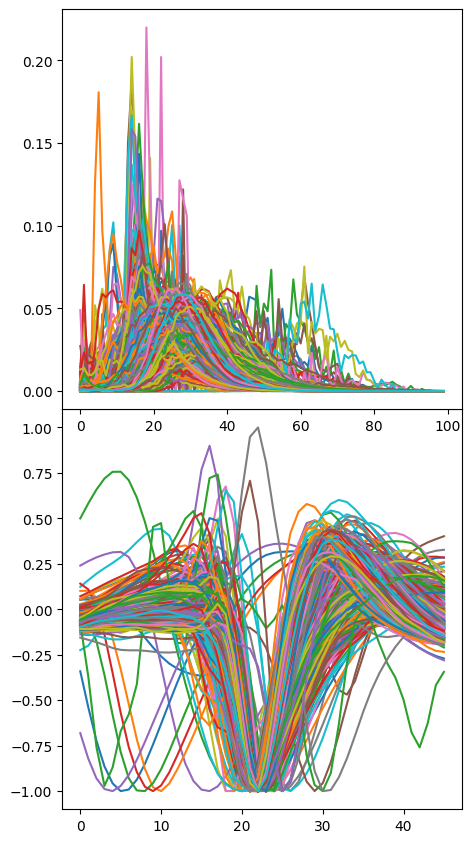

In [14]:
indices_wf = [i for i in range(0, waveforms.shape[1])]
indices_isi = [i for i in range(0, isi_dists.shape[1])]
plt.figure(figsize=(10, 10))
panel1 = plt.axes([0.1, 0.1, 0.4, 0.4])
panel2 = plt.axes([0.1, 0.5, 0.4, 0.4])

for i in range(0, waveforms.shape[0]):
    panel1.plot(indices_wf, waveforms[i])

#panel1.scatter(indices_wf, waveform[0], c='r', s=1)
for i in range(0, isi_dists.shape[0]):
    #print(isi_dist[i])
    panel2.plot(indices_isi, isi_dists[i])

In [15]:
class EphysDatasetLabeled(Dataset):
    def __init__(self, waveforms, isi_dists,labels, normalize=True):
        self.waveforms = np.array(waveforms)
        self.isi_dists = np.array(isi_dists)
        self.labels = np.array(labels)
        #print(len(self.waveforms) , len(self.isi_dists), len(self.labels))
        assert len(self.waveforms) == len(self.isi_dists)
        assert len(self.waveforms) == len(self.labels)
        self.normalize = normalize
        
    def __getitem__(self, idx):
        waveform = torch.as_tensor(self.waveforms[idx, ...]).float()
        
        isi_dist = torch.as_tensor(self.isi_dists[idx, ...]).float()
        isi_dist = torch.log(isi_dist + 1)

        label = torch.as_tensor(self.labels[idx]).long()
        if self.normalize:
            #waveform = (waveform - waveform.mean()) / waveform.std()
            #0 1 normalization
            waveform = (waveform - waveform.min()) / (waveform.max() - waveform.min())
            isi_dist = (isi_dist - isi_dist.mean()) / isi_dist.std()

        waveform = waveform.view(1, 1, -1)
        waveform = F.interpolate(waveform, size=(64,), mode='linear').view(1, -1)
        
        isi_dist = isi_dist.view(1, 1, -1)
        isi_dist = F.interpolate(isi_dist, size=(64,), mode='linear').view(1, -1)

        return waveform, isi_dist, label
    
    def __len__(self):
        return len(self.waveforms)

In [16]:
import torch
is_torchvision_installed = True
try:
    import torchvision
except:
    is_torchvision_installed = False
import torch.utils.data
import random

class BalancedBatchSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, dataset, labels=None):
        self.labels = labels
        self.dataset = dict()
        self.balanced_max = 0
        # Save all the indices for all the classes
        for idx in range(0, len(dataset)):
            label = self._get_label(dataset, idx)
            if label not in self.dataset:
                self.dataset[label] = list()
            self.dataset[label].append(idx)
            self.balanced_max = len(self.dataset[label]) \
                if len(self.dataset[label]) > self.balanced_max else self.balanced_max
        
        # Oversample the classes with fewer elements than the max
        for label in self.dataset:
            while len(self.dataset[label]) < self.balanced_max:
                self.dataset[label].append(random.choice(self.dataset[label]))
        self.keys = list(self.dataset.keys())
        self.currentkey = 0
        self.indices = [-1]*len(self.keys)

    def __iter__(self):
        while self.indices[self.currentkey] < self.balanced_max - 1:
            self.indices[self.currentkey] += 1
            yield self.dataset[self.keys[self.currentkey]][self.indices[self.currentkey]]
            self.currentkey = (self.currentkey + 1) % len(self.keys)
        self.indices = [-1]*len(self.keys)
    
    def _get_label(self, dataset, idx, labels = None):
        if self.labels is not None:
            return self.labels[idx].item()
        else:
            # Trying guessing
            dataset_type = type(dataset)
            if is_torchvision_installed and dataset_type is torchvision.datasets.MNIST:
                return dataset.train_labels[idx].item()
            elif is_torchvision_installed and dataset_type is torchvision.datasets.ImageFolder:
                return dataset.imgs[idx][1]
            else:
                raise Exception("You should pass the tensor of labels to the constructor as second argument")

    def __len__(self):
        return self.balanced_max*len(self.keys)

In [17]:
wf_train, isi_train,label_train = waveform[:350], isi_dist[:350], labels[:350]
wf_val, isi_val,label_val = waveform[350:], isi_dist[350:], labels[350:]

dataset_train = EphysDatasetLabeled(wf_train, isi_train, label_train, normalize=False)
#Get all labels from dataset_train as a torch tensor
targets = torch.tensor([dataset_train[i][2] for i in range(len(dataset_train))])

sampler = BalancedBatchSampler(dataset_train,targets) #Ańadido aqui
#print(sampler)
dataloader_train = DataLoader(dataset_train, batch_size=32, sampler=sampler)

dataset_val = EphysDatasetLabeled(wf_val, isi_val, label_val, normalize=False)
targets_val = torch.tensor([dataset_val[i][2] for i in range(len(dataset_val))])
sampler = BalancedBatchSampler(dataset_val,targets_val) #Ańadido aqui
#print(sampler)
dataloader_val = DataLoader(dataset_val, batch_size=32, sampler=sampler)
#dataloader_val = DataLoader(dataset_val, batch_size=32, shuffle=False)

#Check distribution of label train and label val
print(np.unique(label_train, return_counts=True), np.unique(label_val, return_counts=True))

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.